# PD5, dane FICO
### Tomek Radzikowski


## Model podstawowy i jego ważność zmiennych 

Dla wybranych danych - dane kredytowe USA zastosowałem na początek algorytm XGboost. Wybrany zbiór wydał mi się ciekawy pod względem analizy feature importance, ponież zawiera jedną zmienną, która niejako agreguje inne: ExternalRiskEstimate, czyli ocena amerykańskiego odpowiednika BIKu. Poza tym zbiór jest kompletny pod względem braków danych, wszystkie zmienne oprócz jednej są numeryczne. Wyniki użycia funkcji z pakietu sklrearn "permutation_importance()" są następujące:
<img src="obr/ch0.png">

Można zauważyć, że zmienna, o której pisałem we wstępie "przysłania" inne - jej waga w procesie wyjaśniania to około 40%, natomiast wszystkie inne zmienne mają znacznie mniejszą wagę. Fakt ten nie powinien dziwić, wszak zmienna ta agreguje wiele danych zawartych w innych predyktorach - jest w końcu zagregowaną oceną, dokonaną przez instytucję zewnętrzną. 

## Modyfikacje
### Usunięcie zmiennej ExternalRiskEstimate

Mając na uwadze sytuację opisaną w modelu bazowym zdecydowałem się sprawdzić jak algorytm XGboost radzi sobie, gdy usunę tę "ważną" zmienną. Ponieważ jakość mierzona poprzez AUC nie zmienia się na gorsze (w obu przypadkach około ~72.5%), zatem usunięcie to może być usprawiedliwione. Ważność zmiennych zmienia się w tym przypadku diametralnie, co widać poniżej.
<img src="obr/ch1a.png">

Można zaobserwować przede wszystkim wzrost ważności wszystkich zmiennych i zwiększenie zmienności w ich obrębie. W pierwszym przypadku wszystkie predyktory prócz rzeczonego ExternalRiskEstimate miały wagę nie większą niż 8%. Po usunięciu zmiennej mamy nawet około 18%. Bardzo ładnie unaoczniają się różnice między nimi, które uprzednio były praktycznie niewidoczne. Zupełnie inna jest też kolejność zmiennych, te, które były w modelu pierwszym ważne, teraz potrafią plasować się w zakresie niskiej ważności. Nie widać tutaj specjalnej prawidłowości, co zapewne jest związane z faktem, że model drzewiasty jakim jest XGboost został drastycznie inaczej zbudowany, bez zmiennej, która ograniczała wpływ każdej innej. 


### One-Hot-Encoding

Zmienna określająca maksymalne opóźnienie w spłacie został w danych przedstawiona na skali porządkowej, przyjmującej 8 wartości. W związku z tym dokonałem zakodowania owej zmiennej za pomocą enkodera One-Hot. Zabieg ten podniósł AUC o pewną małą wartość i naturalnie wpłynął na rozkład wagi cech, gdyż zamiast jednego predyktora, pojawiło się 8. Dodatkowo, dla pozostałych cech, zaszły dość duże zmiany. Chociaż zmienna o największej wadze pozostała ta sama - NetFractionRevolvingBurden, to nie tylko zwiększyła swoją przewagę nad kolejną, bowiem druga zmienna zmieniła się z NumTrades90Ever2DerogPubRec na PercentTradesNeverDelq. NumTrades90Ever2DerogPubRec w modelu ze zmienną zakodowaną enkoderem ma bardzo niską wagę. Co więcej, zwiększenie liczby zmiennych spowodowało, podobnie jak w modelu wyjściowym, zmniejszenie ważności i różnicy ważności między cechami.
<img src="obr/ch4a.png">

### Random forest 

Zastosowanie klastyfikatora random forest pozwoliło uzykać inne, ciekawe wyniki. W odróżnieniu od wszystkich wariacji algorytmu XGBoost uzyskano rozkład ważności cech, w którym waga ta jest znacznie równomierniej rozłożona. Nie ma więc widocznej jednej wiądącej cechy (w przypadku XGboost odpowiadała za 18-40% wyjaśnienia), ale wiele równoważnych. Co ciekawe najważniejsza cecha, czyli tym razem nieusunięte ExternalRiskEstimate odpowiadało za 12% versus wspomniane 40% w modelu bazowym. Wobec takich danych stwierdzam, że model random forest nie faworyzuje zmiennej, która dobrze opisuje dane, ale używa innych równomierniej. 
<img src="obr/ch3.png">

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
import matplotlib.pyplot as plt
import re
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

In [32]:
data=pd.read_csv("heloc_dataset_v1.csv")
data.head()

print('braki: ',data.isnull().values.any())

data.RiskPerformance=data.RiskPerformance.replace(to_replace=['Bad', 'Good'], value=[0, 1])
data['RiskPerformance'] = pd.to_numeric(data['RiskPerformance']) 
y=data.pop('RiskPerformance')
X=data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=421)
X_train.head()

braki:  False


,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
5663,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9,...,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9
5140,65,216,6,80,19,1,0,70,7,4,...,30,0,0,0,21,-8,2,1,0,38
3621,61,137,5,58,31,0,0,88,0,4,...,41,6,0,0,49,79,6,4,2,91
8121,84,329,25,158,9,1,0,90,75,6,...,10,9,0,0,0,-8,3,-8,0,50
1483,63,363,8,85,15,0,0,93,-8,6,...,67,0,0,0,91,74,1,4,1,83


In [9]:
model = xgb.XGBClassifier()

train_model=model.fit(X_train, y_train)
pred = train_model.predict(X_test)
print("Accuracy for model 1: %.2f" % (accuracy_score(y_test, pred) * 100))

Accuracy for model 1: 72.39


In [10]:
pi=permutation_importance(model,X_test,y_test)

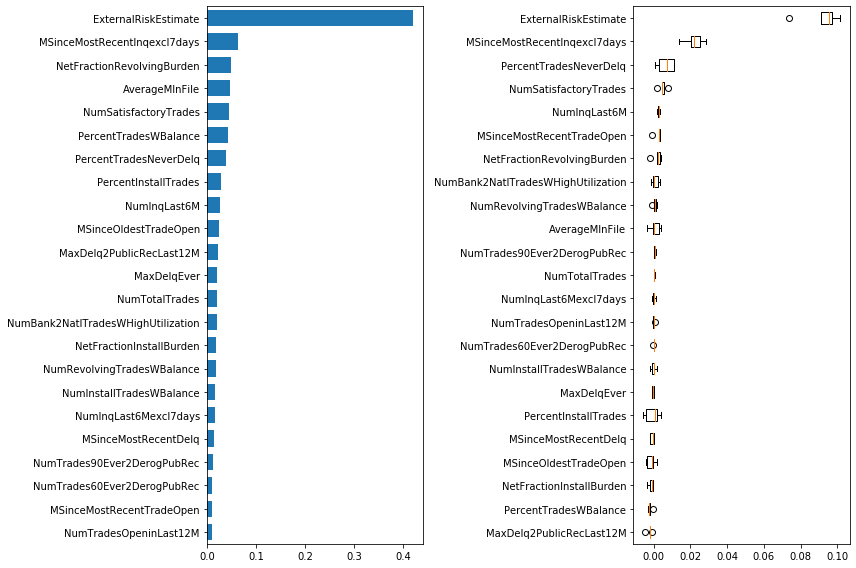

In [11]:
pi_idx = pi.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(model.feature_importances_)
tree_indices = np.arange(0, len(model.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         model.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(np.array(X.columns)[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(model.feature_importances_)))
ax2.boxplot(pi.importances[pi_idx].T, vert=False,
            labels=np.array(X.columns)[pi_idx.astype(int)] )
fig.tight_layout()
plt.show()

In [12]:
pi_idx
np.array(X.columns)[pi_idx.astype(int)] 
type(data)
X_train

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
5663,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9,...,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9
5140,65,216,6,80,19,1,0,70,7,4,...,30,0,0,0,21,-8,2,1,0,38
3621,61,137,5,58,31,0,0,88,0,4,...,41,6,0,0,49,79,6,4,2,91
8121,84,329,25,158,9,1,0,90,75,6,...,10,9,0,0,0,-8,3,-8,0,50
1483,63,363,8,85,15,0,0,93,-8,6,...,67,0,0,0,91,74,1,4,1,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3091,71,240,2,15,3,0,0,100,-7,7,...,0,1,2,2,40,-8,1,-8,0,33
492,88,138,2,71,21,0,0,100,-7,7,...,33,-7,0,0,4,-8,2,1,0,75
2039,69,344,3,103,24,1,0,85,9,3,...,30,0,1,1,38,70,4,3,0,73
5685,74,52,5,26,16,0,0,100,-7,7,...,19,0,1,1,45,56,3,2,0,56


In [22]:
model1 = xgb.XGBClassifier()
X_train=X_train.drop('ExternalRiskEstimate', 1)
X_test=X_test.drop('ExternalRiskEstimate', 1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=421)
train_model1=model1.fit(X_train, y_train)
pred = train_model1.predict(X_test)
print("Accuracy for model 1: %.2f" % (accuracy_score(y_test, pred) * 100))

Accuracy for model 1: 72.50


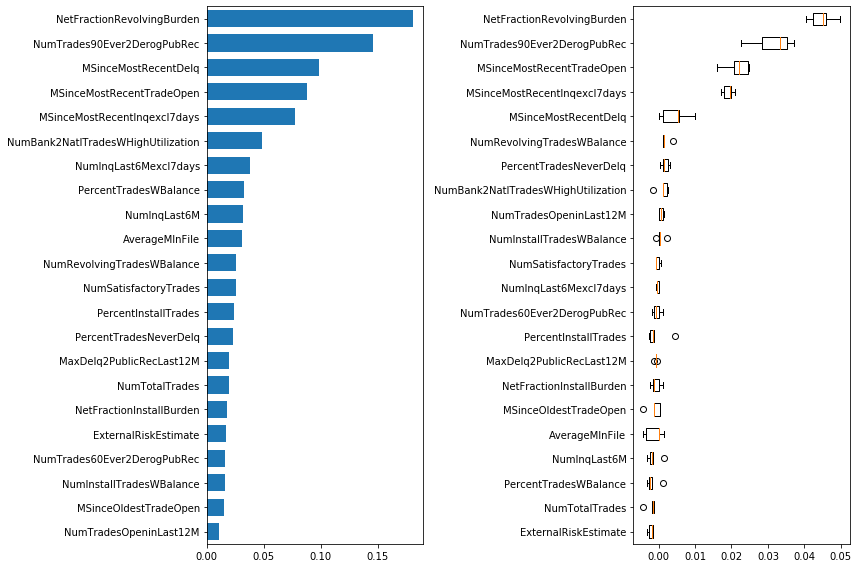

In [23]:
X1=data
X1 = X1.drop('MaxDelqEver',axis = 1)
pi=permutation_importance(model1,X_test,y_test)
pi_idx = pi.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(model1.feature_importances_)
tree_indices = np.arange(0, len(model1.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         model1.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(np.array(X1.columns)[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(model1.feature_importances_)))
ax2.boxplot(pi.importances[pi_idx].T, vert=False,
            labels=np.array(X1.columns)[pi_idx.astype(int)] )
fig.tight_layout()
plt.show()

In [54]:
data.nunique()

ExternalRiskEstimate                   61
MSinceOldestTradeOpen                 526
MSinceMostRecentTradeOpen             112
AverageMInFile                        237
NumSatisfactoryTrades                  74
NumTrades60Ever2DerogPubRec            19
NumTrades90Ever2DerogPubRec            17
PercentTradesNeverDelq                 72
MSinceMostRecentDelq                   87
MaxDelq2PublicRecLast12M               10
MaxDelqEver                             8
NumTotalTrades                         88
NumTradesOpeninLast12M                 19
PercentInstallTrades                   96
MSinceMostRecentInqexcl7days           28
NumInqLast6M                           27
NumInqLast6Mexcl7days                  27
NetFractionRevolvingBurden            128
NetFractionInstallBurden              139
NumRevolvingTradesWBalance             31
NumInstallTradesWBalance               20
NumBank2NatlTradesWHighUtilization     19
PercentTradesWBalance                  95
dtype: int64

In [33]:
model2 = RandomForestClassifier(n_estimators=100, random_state=42)
model2.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(model2.score(X_test, y_test)*100))

Accuracy on test data: 71.93


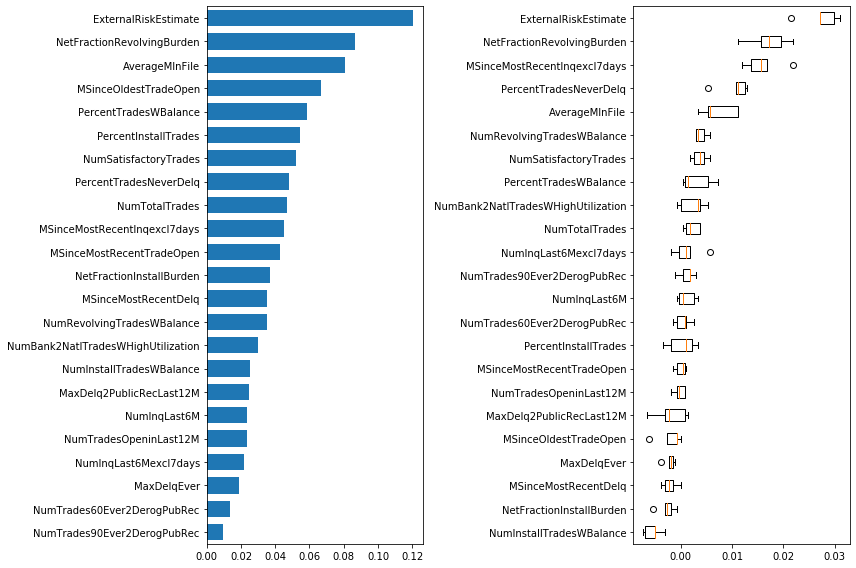

In [34]:
pi=permutation_importance(model2,X_test,y_test)
pi_idx = pi.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(model2.feature_importances_)
tree_indices = np.arange(0, len(model2.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         model2.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(np.array(X.columns)[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(model2.feature_importances_)))
ax2.boxplot(pi.importances[pi_idx].T, vert=False,
            labels=np.array(X.columns)[pi_idx.astype(int)] )
fig.tight_layout()
plt.show()

In [30]:
X4=data
le = pd.get_dummies(X4['MaxDelqEver'])
# Drop column B as it is now encoded
X4 = X4.drop('MaxDelqEver',axis = 1)
X4 = X4.join(le)
# Join the encoded df
X4=X4.drop('ExternalRiskEstimate', 1)
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.25, random_state=421)
X_train.head()

model3 = xgb.XGBClassifier()
#X_train=X_train.drop('ExternalRiskEstimate', 1)
#X_test=X_test.drop('ExternalRiskEstimate', 1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=421)
train_model3=model3.fit(X_train, y_train)
pred = train_model3.predict(X_test)
print("Accuracy for model 1: %.2f" % (accuracy_score(y_test, pred) * 100))

Accuracy for model 1: 72.89


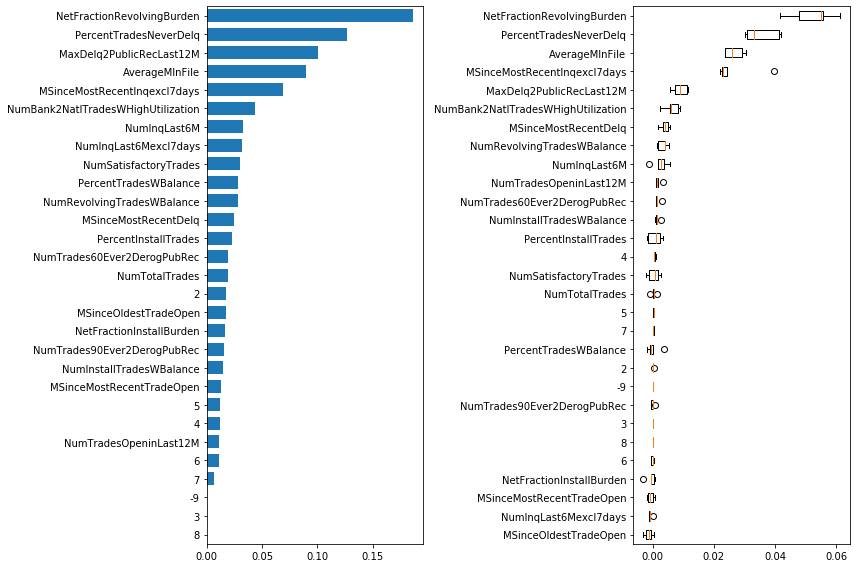

In [31]:
pi=permutation_importance(model3,X_test,y_test)
pi_idx = pi.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(model3.feature_importances_)
tree_indices = np.arange(0, len(model3.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         model3.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(np.array(X4.columns)[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(model3.feature_importances_)))
ax2.boxplot(pi.importances[pi_idx].T, vert=False,
            labels=np.array(X4.columns)[pi_idx.astype(int)] )
fig.tight_layout()
plt.show()